In [1]:
from datasets import cilia, joint_transforms
from utils import training_utils
from models import tiramisu
import adabound

import torch
from torchvision import transforms
from torch.utils import data
from imageio import imwrite, imread

from pathlib import Path
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [2]:
# Specify the path for folder
ROOT = '/home/afarahani/Projects/project2/dataset/data/data/'

RESULTS_PATH = Path('.results/')
WEIGHTS_PATH = Path('.weights/')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)

## Load the Data 
Training Data (input, mask)  
Validation Data (input, mask)  
Test Data (input)

In [3]:
train_joint_transformer = transforms.Compose([
    joint_transforms.ResizeImage(256), 
    joint_transforms.JointRandomHorizontalFlip()
    ])

train_cilia = cilia.Cilia(ROOT, joint_transform = train_joint_transformer)
train_loader = data.DataLoader(train_cilia, batch_size = 1, shuffle = True)

val_cilia = cilia.Cilia(ROOT, 'validate')
val_loader = torch.utils.data.DataLoader(val_cilia, batch_size=1, shuffle=True)

test_cilia = cilia.Cilia(ROOT, 'test')
test_loader = torch.utils.data.DataLoader(test_cilia, batch_size=1, shuffle=False)

Train: 1610
Val: 400
Test: 10
Inputs:  torch.Size([1, 1, 256, 256])
Targets:  torch.Size([1, 256, 256])


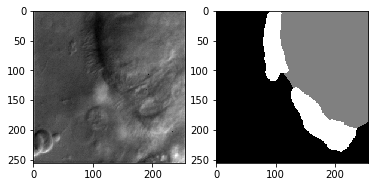

In [5]:
print("Train: %d" %len(train_loader.dataset.imgs))
print("Val: %d" %len(val_loader.dataset.imgs))
print("Test: %d" %len(test_loader.dataset.imgs))

inputs, targets = next(iter(train_loader))
print("Inputs: ", inputs.size())
print("Targets: ", targets.size())

figure, subplot = plt.subplots(1,2)
subplot[0].imshow(inputs[0, 0, :, :], cmap = 'gray')
subplot[1].imshow(targets[0, :, :], cmap = 'gray')

## Training

In [6]:
LR = 1e-4
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 1000

In the `models/tiramisu.py`, there are three different models of Tiramisu implemented -- FCDenseNet57, FCDenseNet67, and FCDenseNet103. For optimal performance, it didn't take us too long to settle on FCDenseNet103. 

For the loss function, we use `NLLLoss` in PyTorch, which is cross-entropy loss, which is the negative log likelihood loss. Alternatively, maybe we can use `CrossEntropyLoss` (need to further test it).

Adam is a good optimizer to use (in our experiments, it works better than SGD, RMSProp, Adagrad).

In [7]:
model = tiramisu.FCDenseNet103(n_classes=3, in_channels=1).cuda()
model.apply(training_utils.weights_init)
# optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)
# criterion = FocalLoss()
# criterion = nn.NLLLoss(weight=torch.tensor([0.7, 0.2, 0.1]).cuda()).cuda()
criterion = torch.nn.NLLLoss().cuda()

Now we start training. Notice we save our model *every step*, because the performance may vary a lot (depending on how you set your parameters). We shall choose the one with low validation loss (high validation accuracy). The training result is from a GPU.

In [ ]:
train_acc, val_acc = [], []

for epoch in range(1, N_EPOCHS+1):
    since = time.time()

    ### Train ###
    trn_loss, trn_err = training_utils.train(model, train_loader, optimizer, criterion, epoch)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(epoch, trn_loss, 1 - trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    ### Validate ###
    val_loss, val_err = training_utils.test(model, val_loader, criterion, epoch)    
    print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss, 1 - val_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))
    
    train_acc.append(1 - trn_err)
    val_acc.append(1 - val_err)
    
    ### Checkpoint ###    
    training_utils.save_weights(model, epoch, val_loss, val_err)

    ### Adjust Lr ###
    training_utils.adjust_learning_rate(LR, LR_DECAY, optimizer, epoch, DECAY_EVERY_N_EPOCHS)

/home/afarahani/.local/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 1
Train - Loss: 0.3700, Acc: 0.8571
Train Time 5m 8s
Val - Loss: 2.2690 | Acc: 0.6368
Total Time 5m 39s

Epoch 2
Train - Loss: 0.3494, Acc: 0.8655
Train Time 4m 59s
Val - Loss: 2.8945 | Acc: 0.6221
Total Time 5m 30s

Epoch 3
Train - Loss: 0.3328, Acc: 0.8724
Train Time 5m 3s
Val - Loss: 2.2299 | Acc: 0.5745
Total Time 5m 34s

Epoch 4
Train - Loss: 0.3162, Acc: 0.8788
Train Time 5m 1s
Val - Loss: 5.3391 | Acc: 0.5362
Total Time 5m 32s

Epoch 5
Train - Loss: 0.3008, Acc: 0.8852
Train Time 5m 0s
Val - Loss: 1.9290 | Acc: 0.6078
Total Time 5m 32s

Epoch 6
Train - Loss: 0.2889, Acc: 0.8892
Train Time 5m 3s
Val - Loss: 4.2835 | Acc: 0.5890
Total Time 5m 34s

Epoch 7
Train - Loss: 0.2742, Acc: 0.8950
Train Time 4m 58s
Val - Loss: 1.8511 | Acc: 0.6425
Total Time 5m 30s

Epoch 8
Train - Loss: 0.2644, Acc: 0.8990
Train Time 5m 6s
Val - Loss: 6.9367 | Acc: 0.5471
Total Time 5m 38s

Epoch 9
Train - Loss: 0.2543, Acc: 0.9029
Train Time 4m 57s
Val - Loss: 2.9630 | Acc: 0.6232
Total Time 5m 29s

## Getting Results

In this part of the notebook, we show how to get results from a saved model.

### Loading a model from a GPU

Notice that we have `cuda()` added.

In [ ]:
model = tiramisu.FCDenseNet103(n_classes=3, in_channels=1).cuda()
model.load_state_dict(torch.load('/home/afarahani/Projects/project2/team-linden-p2/src/tiramisu/.weights/weights-387-1.845-0.241.pth')['state_dict'])

### Writing results

In [ ]:
test_dir = sorted(os.listdir(ROOT + 'test' + '/data/'))
for i, pic in enumerate(test_loader):
    pred = training_utils.get_test_results(model, pic)
    pred_img = pred[0, :, :]
    imwrite(os.path.join(RESULTS_PATH, test_dir[i] + '.png'), pred_img.numpy().astype(np.uint8))

## Test

(first frame of the video, prediction)

In [ ]:
for test_hashcode in test_dir:
    test_frame_0 = imread(ROOT + 'test/data/' + test_hashcode + '/frame0000.png')
    test_mask = imread(ROOT + 'test/masks/' + test_hashcode + '.png')
    test_pred = imread(os.path.join(RESULTS_PATH, test_hashcode + '.png'))
    figure, subplot = plt.subplots(1,3)
    print(test_hashcode)
    subplot[0].imshow(test_frame_0, cmap='gray', aspect = 'equal')
    subplot[1].imshow(test_mask, cmap='gray', aspect = 'equal')
    subplot[2].imshow(test_pred, cmap='gray', aspect = 'equal')
    plt.show()